He realizado la práctica final usando el dataset de la competición de Kaggle: Predict Student Performance from Game Play

Link a la competición: https://www.kaggle.com/competitions/predict-student-performance-from-game-play

# Librerías

In [ ]:
from google.colab import files
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Obtención de los Datos desde Kaggle

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Carga el archivo JSON de credenciales
files.upload()

# Mueve el archivo a la ubicación correcta
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Cambia los permisos del archivo
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c predict-student-performance-from-game-play

100% 968M/968M [00:31<00:00, 32.9MB/s]
100% 968M/968M [00:31<00:00, 31.8MB/s]


In [ ]:
# Nombre del archivo ZIP descargado
zip_filename = '/content/predict-student-performance-from-game-play.zip'

# Descomprime el archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()

# 1. Validación de los Datos

Trabajaremos con el archivo Train Data

In [ ]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

df = pd.read_csv('/content/train.csv', dtype=dtypes)
print("El tamaño del dataset es {}".format(df.shape))

El tamaño del dataset es (26296946, 20)


In [ ]:
df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [ ]:
df.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [ ]:
print("Número de duplicados: ", df[df.duplicated()].shape)

Número de duplicados:  (0, 20)


In [ ]:
df.isna().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

Imputaré los missings más adelante.

In [ ]:
df.dtypes

session_id           int64
index                int64
elapsed_time         int32
event_name        category
name              category
level                uint8
page               float64
room_coor_x        float32
room_coor_y        float32
screen_coor_x      float32
screen_coor_y      float32
hover_duration     float32
text              category
fqid              category
room_fqid         category
text_fqid         category
fullscreen        category
hq                category
music             category
level_group       category
dtype: object

Vamos a echar un vistazo a las distintas variables, y algunas categóricas las transformaremos a numéricas.

In [ ]:
le = LabelEncoder()

In [ ]:
df['event_name'].unique()

['cutscene_click', 'person_click', 'navigate_click', 'observation_click', 'notification_click', ..., 'object_hover', 'map_hover', 'map_click', 'checkpoint', 'notebook_click']
Length: 11
Categories (11, object): ['checkpoint', 'cutscene_click', 'map_click', 'map_hover', ...,
                          'object_click', 'object_hover', 'observation_click', 'person_click']

In [ ]:
df['event_name'] = le.fit_transform(df['event_name'])
df['event_name'].unique()

array([ 1, 10,  4,  9,  6,  7,  8,  3,  2,  0,  5])

In [ ]:
df['name'].unique()

['basic', 'undefined', 'close', 'open', 'prev', 'next']
Categories (6, object): ['basic', 'close', 'next', 'open', 'prev', 'undefined']

In [ ]:
df['name'] = le.fit_transform(df['name'])
df['name'].unique()

array([0, 5, 1, 3, 4, 2])

In [ ]:
df['text'].unique()

['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', 'Can I come, Gramps?', ..., 'Come on, Jo!', 'Meet me back in my office and we'll get start..., 'Here I am!', 'Wells sabotaged Gramps!', 'AND he stole Teddy!']
Length: 598
Categories (597, object): ['*COUGH COUGH COUGH*', '*cough cough*', '*grumble grumble*',
                           'A boring old shirt.', ..., 'Wells sabotaged Gramps!',
                           'Wells! Where's Teddy? Is he okay?', 'Who is Teddy?', 'Why don't you prove your case?']

In [ ]:
df['fqid'].unique()

['intro', 'gramps', 'teddy', 'photo', NaN, ..., 'block_badge', 'fox', 'block_badge_2', 'block_1', 'chap2_finale']
Length: 129
Categories (128, object): ['archivist', 'archivist_glasses', 'block', 'block_0', ..., 'fox',
                           'block_badge_2', 'block_1', 'chap2_finale']

In [ ]:
df['room_fqid'].unique()

['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.stacks', ..., 'tunic.historicalsociety.cage', 'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center', 'tunic.flaghouse.entry', 'tunic.capitol_2.hall']
Length: 19
Categories (19, object): ['tunic.capitol_0.hall', 'tunic.capitol_1.hall', 'tunic.capitol_2.hall',
                          'tunic.drycleaner.frontdesk', ..., 'tunic.kohlcenter.halloffame',
                          'tunic.library.frontdesk', 'tunic.library.microfiche', 'tunic.wildlife.center']

In [ ]:
df['text_fqid'].unique()

['tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.gramps.intro_0..., 'tunic.historicalsociety.closet.teddy.intro_0_..., NaN, 'tunic.historicalsociety.closet.teddy.intro_0_..., ..., 'tunic.wildlife.center.fox.concern', 'tunic.library.frontdesk.block_badge_2', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
Length: 127
Categories (126, object): ['tunic.capitol_0.hall.boss.talktogramps', 'tunic.capitol_0.hall.chap1_finale_c',
                           'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.capitol_1.hall.boss.writeitup', ...,
                           'tunic.library.frontdesk.block_badge_2', 'tunic.historicalsociety.entry.gramps.hub',
                           'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']

In [ ]:
df['fullscreen'].unique()

['0', '1']
Categories (2, object): ['0', '1']

In [ ]:
df['fullscreen'] = df['fullscreen'].astype(int)
df['fullscreen'].unique()

array([0, 1])

In [ ]:
df['hq'].unique()

['0', '1']
Categories (2, object): ['0', '1']

In [ ]:
df['hq'] = df['hq'].astype(int)
df['hq'].unique()

array([0, 1])

In [ ]:
df['music'].unique()

['1', '0']
Categories (2, object): ['0', '1']

In [ ]:
df['music'] = df['music'].astype(int)
df['music'].unique()

array([1, 0])

In [ ]:
df['level_group'].unique()

['0-4', '5-12', '13-22']
Categories (3, object): ['0-4', '13-22', '5-12']

In [ ]:
map = {'0-4': 1, '5-12': 2, '13-22': 3}
df['level_group'] = df['level_group'].replace(map)
df['level_group'].unique()

[1, 2, 3]
Categories (3, int64): [1, 3, 2]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      int64   
 4   name            int64   
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int64   
 17  hq              int64   
 18  music           int64   
 19  level_group     category
dtypes: category(5), float32(5), float64(1), int32(1), int64(7), uint8(1)
memory usage: 2.4 GB


# 2. Análisis Exploratorio

Veamos cómo se distribuyen algunas variables.

Echemos un vistazo a las variables binarias:

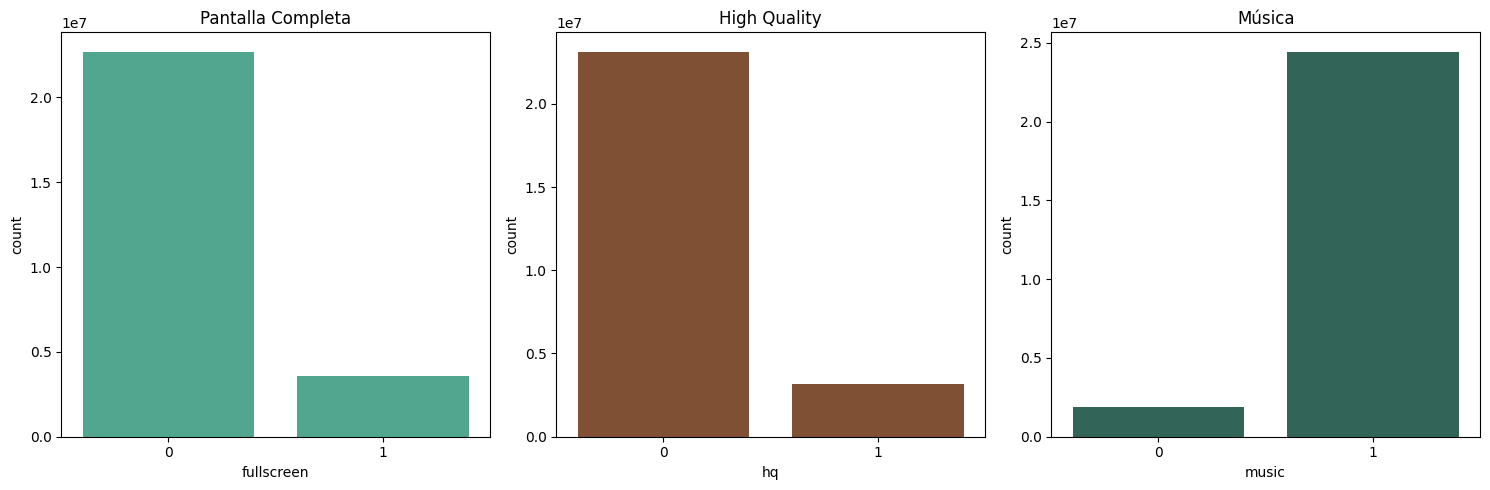

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x="fullscreen", data=df, ax=axes[0], color='#44B497' )
axes[0].set_title("Pantalla Completa")

sns.countplot(x="hq", data=df, ax=axes[1], color='#8C4D28')
axes[1].set_title("High Quality")

sns.countplot(x="music", data=df, ax=axes[2], color='#2A6C5B')
axes[2].set_title("Música")

plt.tight_layout()
plt.show()

Veamos si la coordenadas de la pantalla están muy concentradas en algunos puntos:

<Axes: xlabel='screen_coor_x', ylabel='screen_coor_y'>

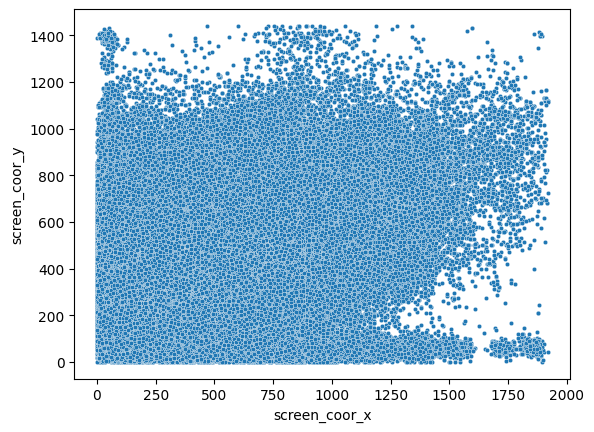

In [ ]:
sns.scatterplot(data=df, x='screen_coor_x', y='screen_coor_y', s=10)

Están distribuidos por casi toda la pantalla.

Veamos la duración de los tiempos en elapsed_time, y hover_duration:

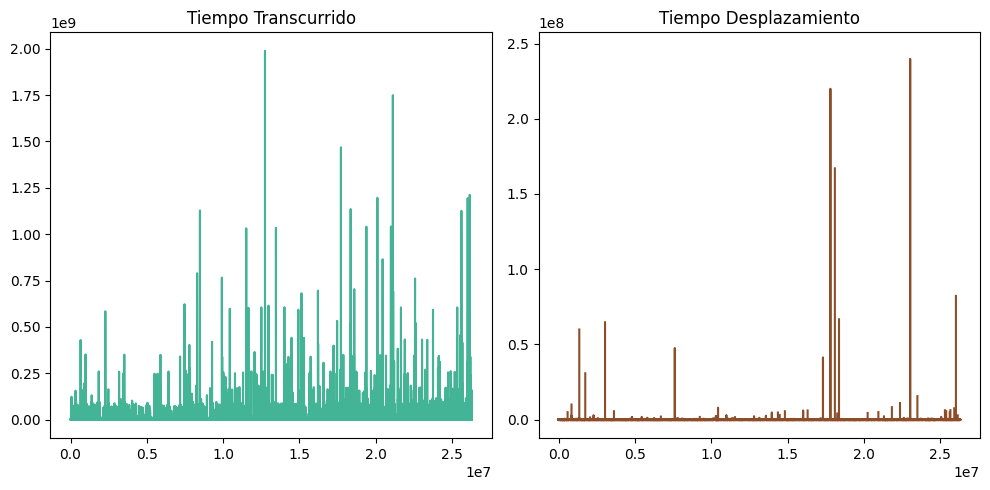

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range(1, len(df['elapsed_time'])+1), df['elapsed_time'], color='#44B497')
axes[0].set_title("Tiempo Transcurrido")

axes[1].plot(range(1, len(df['hover_duration'])+1), df['hover_duration'], color='#8C4D28')
axes[1].set_title("Tiempo Desplazamiento")

plt.tight_layout()
plt.show()

Veamos las correlaciones:

<ipython-input-3-b71f1ad88eb2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlaciones = df.corr()


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
session_id,1.000000,-0.037144,0.023360,0.001625,-0.002618,-0.002836,0.013753,-0.000144,-0.003722,0.007001,0.011294,0.001839,0.035642,-0.008608,0.055155
index,-0.037144,1.000000,0.077711,-0.000016,0.066323,0.658861,0.358802,-0.008766,-0.157396,0.026612,0.029549,-0.002083,-0.016499,-0.004524,0.020011
elapsed_time,0.023360,0.077711,1.000000,0.001567,0.001707,0.077311,0.076106,-0.002819,-0.018350,0.000510,0.001004,0.017643,0.009317,0.005419,-0.002104
event_name,0.001625,-0.000016,0.001567,1.000000,-0.423726,0.022757,NaN,0.074539,0.013492,0.010788,-0.115142,0.004364,0.002747,0.001547,-0.004474
name,-0.002618,0.066323,0.001707,-0.423726,1.000000,0.051244,0.049196,-0.048303,-0.125091,-0.023369,0.135025,0.003316,-0.004642,-0.002354,0.007921
level,-0.002836,0.658861,0.077311,0.022757,0.051244,1.000000,0.950965,-0.048372,-0.238980,0.031689,0.048497,-0.002294,0.000728,-0.001425,0.002678
page,0.013753,0.358802,0.076106,NaN,0.049196,0.950965,1.000000,0.004870,-0.095950,0.008742,-0.004217,NaN,0.000845,-0.000944,0.003926
room_coor_x,-0.000144,-0.008766,-0.002819,0.074539,-0.048303,-0.048372,0.004870,1.000000,0.079033,0.687503,-0.174644,NaN,-0.004769,-0.001764,0.002458
room_coor_y,-0.003722,-0.157396,-0.018350,0.013492,-0.125091,-0.238980,-0.095950,0.079033,1.000000,0.090904,-0.773422,NaN,0.003291,0.001496,-0.002521
screen_coor_x,0.007001,0.026612,0.000510,0.010788,-0.023369,0.031689,0.008742,0.687503,0.090904,1.000000,-0.119515,NaN,0.018650,0.004258,0.006376


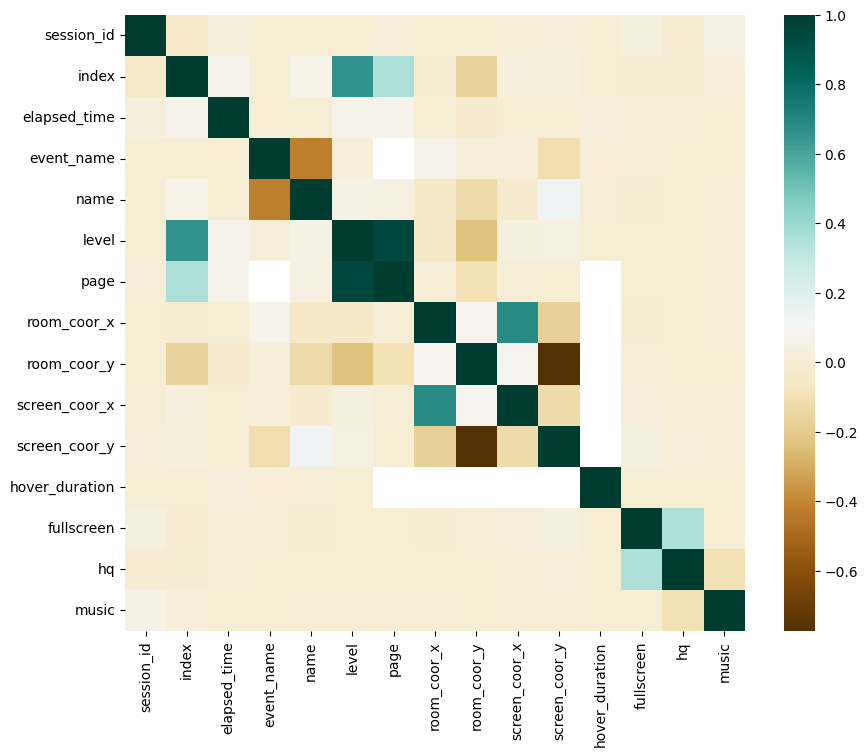

In [ ]:
plt.figure(figsize=(10,8))
correlaciones = df.corr()
sns.heatmap(correlaciones,cmap="BrBG")
correlaciones

Observamos que están relacionadas las coordenadas, name y event_name, que hacen referencia a dos eventos distintos, así que no eliminaremos ninguna; y lo mismo pasa con page y level. Nos quedaremos con dos de las cuatro variables de coordenadas más adelante.

### Labels

Carguemos las Etiquetas.

In [ ]:
labels = pd.read_csv('/content/train_labels.csv')

In [ ]:
labels.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [ ]:
labels['pregunta'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels['session_id'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )

In [ ]:
labels.head()

,session_id,correct,pregunta
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


<Axes: >

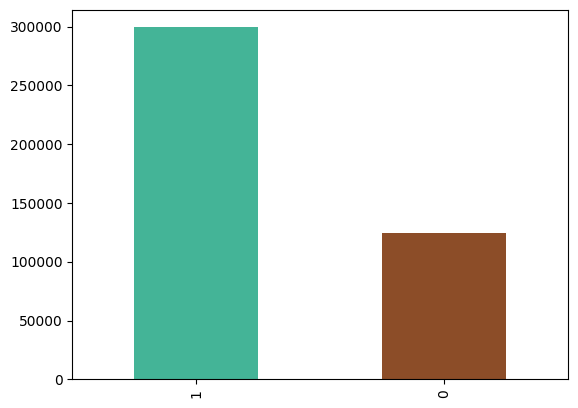

In [ ]:
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['#44B497', '#8C4D28'])

Están un poco desbalanceados, pero no será necesario realizar oversampling o undersampling, ya que no es exagerada la diferencia.

En los resultados, obtendremos mejores predicciones para las respuestas correctas, y habrá bastantes respuestas incorrectas que las predecirá como correctas debido a esta diferencia.

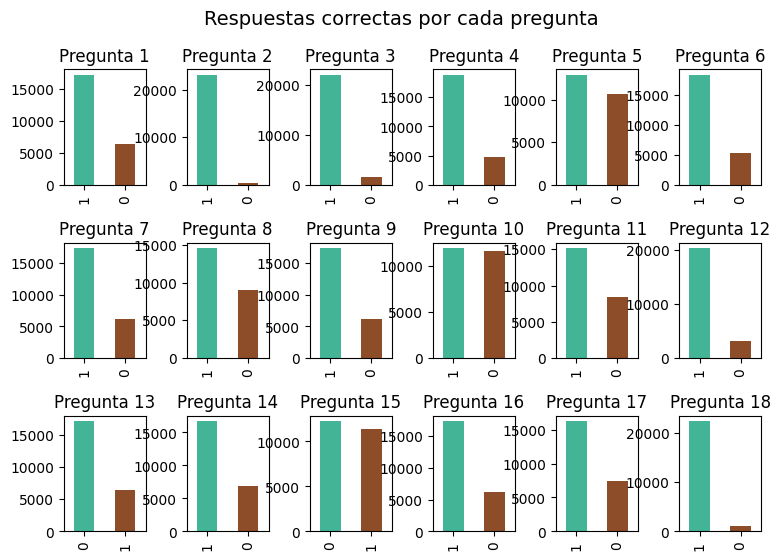

In [ ]:
plt.figure(figsize=(9, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Respuestas correctas por cada pregunta", fontsize=14, y=0.98)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(3, 6, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.pregunta == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['#44B497', '#8C4D28'])
    
    # chart formatting
    ax.set_title("Pregunta " + str(n))
    ax.set_xlabel("")

# 3. Preparación de los datos

Antes de entrenar los datos, debemos entender cómo se asocian los grupos de niveles y las preguntas entre sí.

En este juego, el primer punto de control del cuestionario (es decir, las preguntas 1 a 3) se encuentra después de completar los niveles del 0 al 4. Por lo tanto, para entrenar las preguntas 1 a 3, utilizaremos datos del grupo de niveles 0-4. De manera similar, utilizaremos datos del grupo de niveles 5-12 para entrenar las preguntas del 4 al 13, y datos del grupo de niveles 13-22 para entrenar las preguntas del 14 al 18.

In [ ]:
print(df['room_coor_x'].nunique())
print(df['room_coor_y'].nunique())
print(df['screen_coor_x'].nunique())
print(df['screen_coor_y'].nunique())

12538215
9551136
57477
102591


Nos quedaremos solo con room_coord, ya que tenían una correlación alta con screen_coord, como habíamos visto antes. Además, tiene más variabilidad de datos, que nos aportarán más información.

Además solo contaremos name, y quitaremos event_name, room_fqid, fullscreen, hq, music ya que aparecen el mismo número de veces, por ocurrir todas en un mismo evento.

In [ ]:
CATEGORICAL1 = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
CATEGORICAL2 = ['name','fqid', 'text_fqid']
NUMERICAL1 = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'hover_duration']
NUMERICAL2 = ['elapsed_time','hover_duration']

def feature_engineer(df):
    dfs = []
    for c in CATEGORICAL1:
        tmp = df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in CATEGORICAL2:
        tmp = df.groupby(['session_id','level_group'])[c].agg('count')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
    for c in NUMERICAL1:
        tmp = df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL1:
        tmp = df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in NUMERICAL1:
        tmp = df.groupby(['session_id','level_group'])[c].agg('median')
        tmp.name = tmp.name + '_median'
        dfs.append(tmp)
    for c in NUMERICAL2:
        tmp = df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [ ]:
model_df = feature_engineer(df)
print("Full prepared dataset shape is {}".format(model_df.shape))

Full prepared dataset shape is (70686, 29)


In [ ]:
model_df.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,name_count,fqid_count,text_fqid_count,elapsed_time,...,room_coor_y_std,hover_duration_std,elapsed_time_median,level_median,page_median,room_coor_x_median,room_coor_y_median,hover_duration_median,elapsed_time_sum,hover_duration_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,1,10,3,30,7,17,165,104,62,8.579356e+04,...,129.292411,3227.370757,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0
20090312431273200,3,10,3,49,12,35,420,313,196,1.040601e+06,...,230.370874,1305.088265,1046134.0,18.0,-1.0,-43.891830,-120.395386,315.0,437052322,24298.0
20090312431273200,2,10,3,39,11,24,296,235,126,3.572052e+05,...,137.409476,1316.408315,352460.5,8.0,-1.0,-16.105585,-86.000000,334.0,105732736,29080.0
20090312433251036,1,11,4,22,6,11,139,97,61,9.763342e+04,...,156.186242,2114.876406,98310.0,2.0,0.0,-86.761826,-95.000000,417.0,13571045,11030.0
20090312433251036,3,11,6,73,16,43,1297,762,229,2.498852e+06,...,234.279590,1990.705518,2698328.0,17.0,5.0,-13.879383,-125.121628,226.0,3241011333,181537.0


Vamos a replicar la información que tenemos antes de los 3 checkpoints, ya que, por ejemplo, para predecir si acertará las preguntas 1, 2, y 3, la información de la que disponemos es la misma.

Además lo ordenamos por el id de sesión, y el grupo.

In [ ]:
condicion1 = model_df['level_group'] == 1
condicion2 = model_df['level_group'] == 2
condicion3 = model_df['level_group'] == 3
model_df1 = pd.concat([model_df, model_df[condicion1].copy(), model_df[condicion1].copy()])
model_df2 = pd.concat([model_df1, model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy(), model_df[condicion2].copy()])
model_df3 = pd.concat([model_df2, model_df[condicion3].copy(), model_df[condicion3].copy(), model_df[condicion3].copy(), model_df[condicion3].copy()])
model_df3['level_group'] = pd.to_numeric(model_df3['level_group'])
model_df3 = model_df3.sort_values(['session_id','level_group'])
model_df3.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,name_count,fqid_count,text_fqid_count,elapsed_time,...,room_coor_y_std,hover_duration_std,elapsed_time_median,level_median,page_median,room_coor_x_median,room_coor_y_median,hover_duration_median,elapsed_time_sum,hover_duration_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,129.292411,3227.370757,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,129.292411,3227.370757,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,129.292411,3227.370757,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0
20090312431273200,2,10,3,39,11,24,296,235,126,357205.189189,...,137.409476,1316.408315,352460.5,8.0,-1.0,-16.105585,-86.000000,334.0,105732736,29080.0
20090312431273200,2,10,3,39,11,24,296,235,126,357205.189189,...,137.409476,1316.408315,352460.5,8.0,-1.0,-16.105585,-86.000000,334.0,105732736,29080.0


Esto lo hacemos para añadir ahora las columnas del número de pregunta, y si es correcta o no, del dataframe labels.

In [ ]:
labels = labels.sort_values(['session_id','pregunta'])

In [ ]:
labels.head()

,session_id,correct,pregunta
0,20090312431273200,1,1
23562,20090312431273200,1,2
47124,20090312431273200,1,3
70686,20090312431273200,1,4
94248,20090312431273200,1,5


In [ ]:
labels_final = labels
labels_final.set_index(model_df3.index, inplace=True)

In [ ]:
df_final = model_df3
df_final.insert(len(df_final.columns), 'pregunta', labels_final['pregunta'])
df_final.insert(len(df_final.columns), 'correct', labels_final['correct'])

In [ ]:
df_final.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,name_count,fqid_count,text_fqid_count,elapsed_time,...,elapsed_time_median,level_median,page_median,room_coor_x_median,room_coor_y_median,hover_duration_median,elapsed_time_sum,hover_duration_sum,pregunta,correct
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0,1,1
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0,2,1
20090312431273200,1,10,3,30,7,17,165,104,62,85793.557576,...,87242.0,2.0,-1.0,-3.196174,-80.775925,325.0,14155937,19116.0,3,1
20090312431273200,2,10,3,39,11,24,296,235,126,357205.189189,...,352460.5,8.0,-1.0,-16.105585,-86.000000,334.0,105732736,29080.0,4,1
20090312431273200,2,10,3,39,11,24,296,235,126,357205.189189,...,352460.5,8.0,-1.0,-16.105585,-86.000000,334.0,105732736,29080.0,5,1


Ya tenemos el dataframe final que utilizaremos para entrenar y evaluar los modelos.

# 4. Algoritmos de Clasificación

In [ ]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = df_final.values

y = (data[:,30:31])     
X = data[:,1:30]      

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (339292, 29)
Datos test:  (84824, 29)


## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.6911723097236632
Precisión de 0.7470203541773827
La sensibilidad, o recall es 0.8498319763262167
El f1 score es 0.7951164573198392


In [ ]:
algoritmos= pd.DataFrame({'Accuracy':[],'Precision':[],'Recall':[],'F1Score':[]})
algoritmos.loc['KNN']=[accuracy,precision,recall,f1score]

[[ 7797 17214]
 [ 8982 50831]]


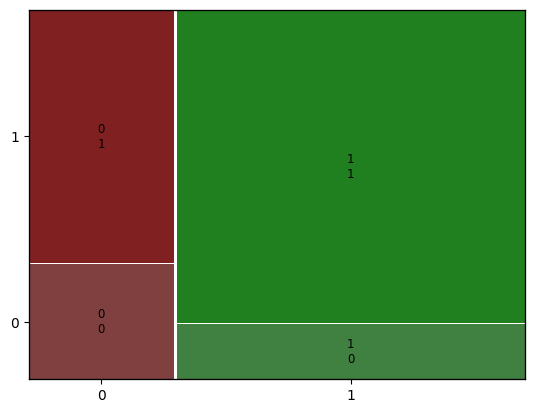

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## Árbol de Decisión Simple

In [ ]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.6673465057059322
Precisión de 0.7678625928312252
La sensibilidad, o recall es 0.7571430959824788
El f1 score es 0.7624651699202801


In [ ]:
algoritmos.loc['ÁRBOL']=[accuracy,precision,recall,f1score]

[[11327 13684]
 [14535 45278]]


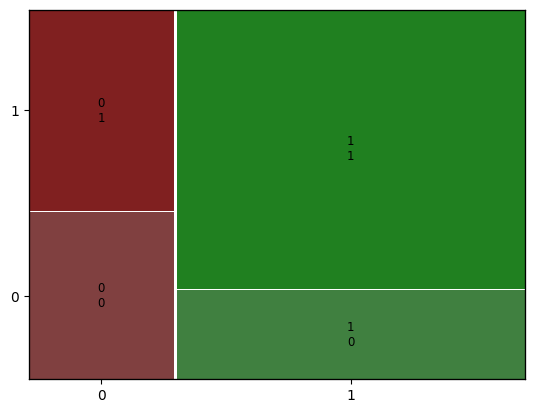

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## Bagging

In [ ]:
bagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=10, random_state=1)

bagging_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=1)

In [ ]:
y_pred = bagging_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.7127110251815524
Precisión de 0.7866060743280396
La sensibilidad, o recall es 0.8131844247905974
El f1 score es 0.7996744679276925


In [ ]:
algoritmos.loc['BAGGING']=[accuracy,precision,recall,f1score]

[[11816 13195]
 [11174 48639]]


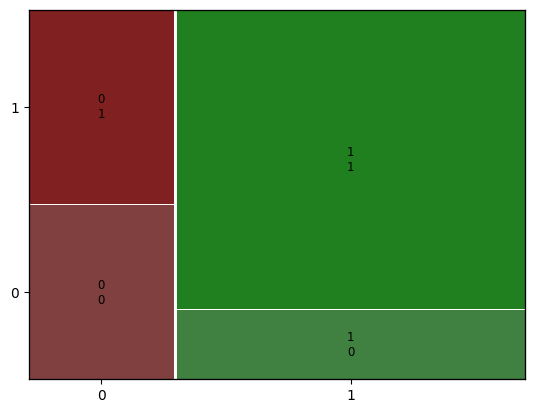

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)

rf_clf.fit(X_train, y_train)

<ipython-input-23-45027c8b8cba>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.7220126379326606
Precisión de 0.7844972439893843
La sensibilidad, o recall es 0.8352030495042884
El f1 score es 0.8090564570984355


In [ ]:
algoritmos.loc['RANDOM FOREST']=[accuracy,precision,recall,f1score]

[[11288 13723]
 [ 9857 49956]]


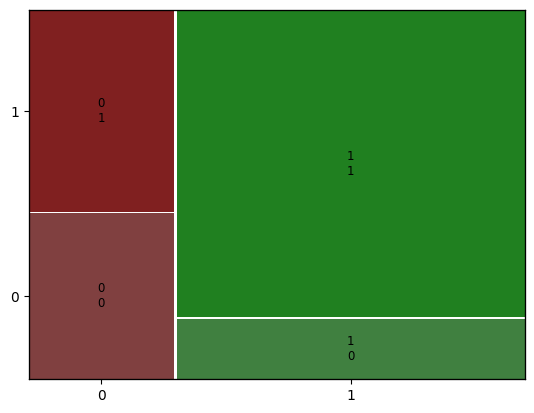

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## Gradient Boost

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=1)

gb_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(random_state=1)

In [ ]:
y_pred = gb_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.749776006790531
Precisión de 0.762104004781829
La sensibilidad, o recall es 0.9379231939544915
El f1 score es 0.8409218662169758


In [ ]:
algoritmos.loc['GRADIENT BOOST']=[accuracy,precision,recall,f1score]

[[ 7499 17512]
 [ 3713 56100]]


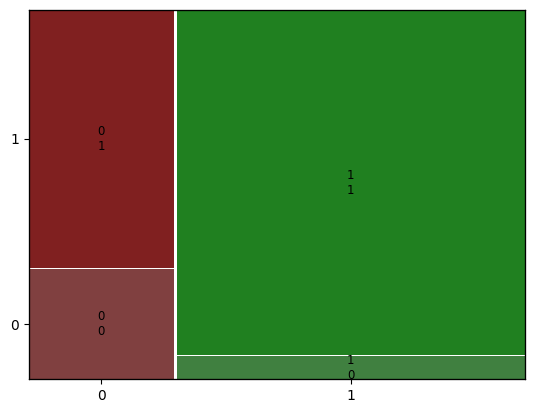

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=1)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.7551282655852117
Precisión de 0.7740943555181129
La sensibilidad, o recall es 0.9217227024225503
El f1 score es 0.8414826799355887


In [ ]:
algoritmos.loc['XGBOOST']=[accuracy,precision,recall,f1score]

[[ 8922 16089]
 [ 4682 55131]]


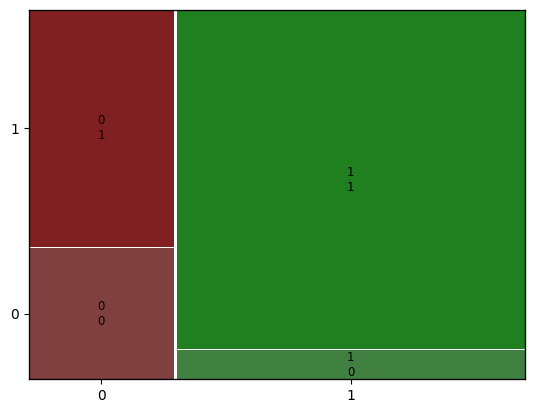

In [ ]:
print(cm)
mosaic(cm)
plt.show()

## Red Neuronal 

In [ ]:
classifier = Sequential()

classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))

classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))

classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 10, epochs = 50)

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

Epoch 1/50
33930/33930 [==============================] - 62s 2ms/step - loss: 7.4103 - accuracy: 0.7052
Epoch 2/50
33930/33930 [==============================] - 61s 2ms/step - loss: 0.6060 - accuracy: 0.7058
Epoch 3/50
33930/33930 [==============================] - 58s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 4/50
33930/33930 [==============================] - 58s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 5/50
33930/33930 [==============================] - 58s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 6/50
33930/33930 [==============================] - 59s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 7/50
33930/33930 [==============================] - 58s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 8/50
33930/33930 [==============================] - 59s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 9/50
33930/33930 [==============================] - 58s 2ms/step - loss: 0.6059 - accuracy: 0.7058
Epoch 10/50
33930/33930 [==============================

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.7051424125247572
Precisión de 0.7051424125247572
La sensibilidad, o recall es 1.0
El f1 score es 0.8270774421482747


In [ ]:
algoritmos.loc['Red Neuronal']=[accuracy,precision,recall,f1score]

# 5. Evaluación de los Modelos

In [ ]:
print(algoritmos.sort_values(by='F1Score',ascending=False))

                Accuracy  Precision    Recall   F1Score
XGBOOST         0.755128   0.774094  0.921723  0.841483
GRADIENT BOOST  0.749776   0.762104  0.937923  0.840922
Red Neuronal    0.705142   0.705142  1.000000  0.827077
RANDOM FOREST   0.722013   0.784497  0.835203  0.809056
BAGGING         0.712711   0.786606  0.813184  0.799674
KNN             0.691172   0.747020  0.849832  0.795116
ÁRBOL           0.667347   0.767863  0.757143  0.762465


Observando la lista nos quedaríamos con el modelo XGBoost, que obtiene unas mejores métricas a la hora de evaluar su desempeño.

## Hiperparametrización

Ya que el XGBoost nos ha salido que es el mejor modelo, vamos a buscar los mejores learning_rate, max_depth, y n_estimators. 

In [ ]:
model = XGBClassifier()
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7], 'n_estimators': [100, 200, 300]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...in=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]})

In [ ]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy de {}'.format(accuracy))
print('Precisión de {}'.format(precision))
print('La sensibilidad, o recall es {}'.format(recall))
print('El f1 score es {}'.format(f1score))

Accuracy de 0.7569320003772517
Precisión de 0.774832765366654
La sensibilidad, o recall es 0.9237289552438434
El f1 score es 0.8427547284929835


Observamos, que hemos mejorado un poco las métricas con la elección de estos hiperparámetros.